In [2]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import os, sys
import pickle as pkl
import matplotlib as mpl
import copy
from scipy import interpolate


sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")

from DLScommonTools import *
from unpackConfigurationsMK import *
from LRBv21 import *


%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()


# IO

In [11]:
file_paths = {
    "V10" : os.path.join(r"C:\Users\mikek\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc"),
     "V10X" : os.path.join(r"C:\Users\mikek\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc"),
     "SPR38" : os.path.join(r"C:\Users\mikek\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc")}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for design in designs:  
    eqb[design] = dict()

    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 100)

In [6]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.02,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


# Reference result

In [ ]:
file_write(store, "2-fix_outerloop.pkl")

In [106]:
cvar = "density"
design = "SPR38"

store = dict()
# for cvar in ["power"]:
for cvar in ["density", "impurity_frac", "power"]:
    store[cvar] = dict()
    
    for side in ["iu", "ou"]:
    # for side in ["iu"]:
        d = eqb[design][side].copy() # Load in single profile into dictionary "d"
        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 5) # Solve at these parallel positions

        if side == "iu":
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Inner has more heat flux density

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-5, Ttol=1e-5)
        
        store[cvar][side] = copy.deepcopy(results)

Solving...0...4...6...8...9...Complete in 7.7 seconds
Solving...0...12...21...28...32...Complete in 8.6 seconds
Solving...0...4...6...8...9...Complete in 7.9 seconds
Solving...0...12...21...28...32...Complete in 8.3 seconds
Solving...0...4...6...8...9...Complete in 8.8 seconds
Solving...0...12...21...28...32...Complete in 8.6 seconds


Text(0.5, 1.0, 'Inner divertor')

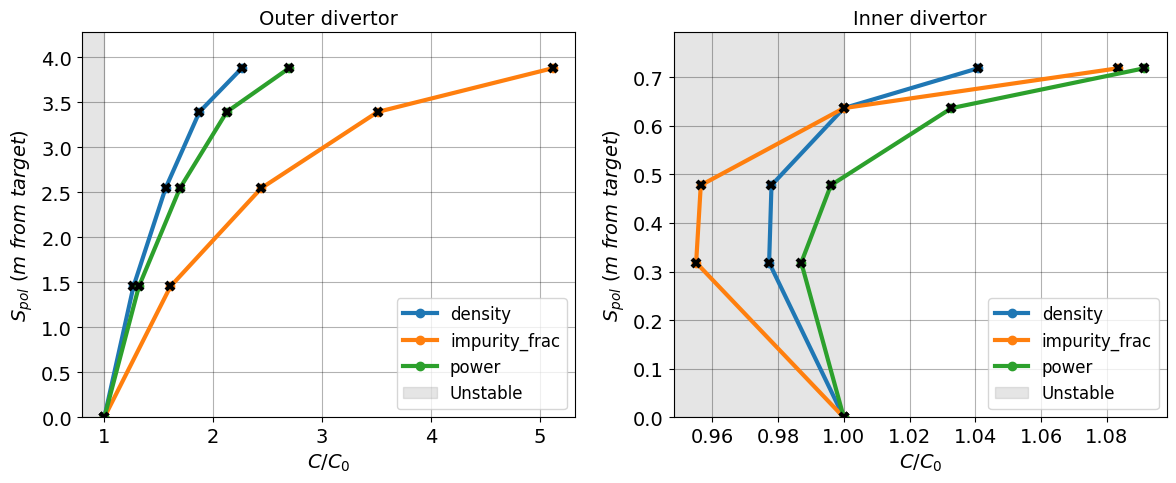

In [107]:
labels = {"cvar_trim":"$n_{u}\ (m^{-3})$", "crel_trim":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}
labels = {"cvar":"$n_{u}\ (m^{-3})$", "crel":"$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$"}

cvar = "impurity_frac"
fig, axes = plt.subplots(1,2, figsize = (14,5))
ax = axes[0]

basis = "crel"

ref = file_read(r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\1-baseline.pkl")

for k, side in enumerate(["ou", "iu"]):
    for i, cvar in enumerate(["density", "impurity_frac", "power"]):
        
        o = store[cvar][side].copy()
        r = ref[cvar][side].copy()
        x = o[basis]        
        xr = r[basis]
        if cvar == "power":
            x = 1/x
            xr = 1/xr
        axes[k].plot(x, o["SpolPlot"],  marker = "o", markersize = 6, linewidth = 3,  label = cvar)
        axes[k].plot(xr, o["SpolPlot"],  marker = "x", markersize = 6, linewidth = 0,  color = "k", markeredgewidth=3)


for ax in axes:
    
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    
    ylims = ax.get_ylim()
    ylims_new = (0,ylims[1]+ylims[1]*0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between([xlims[0],1],0,ylims_new[1], color = "grey", alpha = 0.2, label = "Unstable")   
    ax.set_xlim(xlims)
    
    ax.grid(color ="black", alpha = 0.3)
    ax.set_xlabel("$C/C_{0}$")
    # ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend(fontsize = 12)
    # ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

Text(0, 0.5, 'error1')

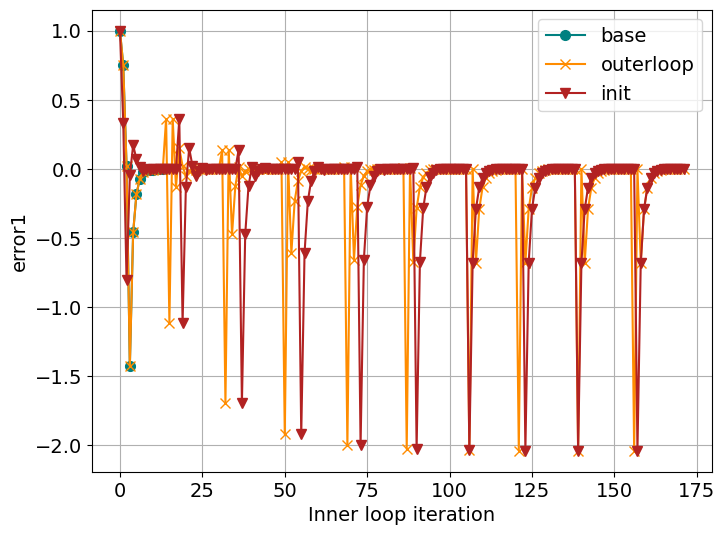

In [103]:
fig, ax = plt.subplots()

# for k, side in enumerate(["ou", "iu"]):
#     for i, cvar in enumerate(["density", "impurity_frac", "power"]):
#         o = store[cvar][side].copy()
#         ax.plot(o["logs"][0]["error1"], lw = 1)

cases = {
    "base":r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\1-baseline.pkl",
    "outerloop":r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\2-fix_outerloop.pkl",
    "init":r"C:\Users\mikek\OneDrive\Project\DLS\Notebooks\fixes\3-fix_init.pkl"}

markers = ["o", "x", "v"]
colors = ["teal", "darkorange", "firebrick"]
cvar = "power"
side = "ou"
for i, case in enumerate(cases):
    store = file_read(cases[case])
    o = store[cvar][side].copy()
    ax.plot(o["logs"][0]["error1"], lw = 1.5, label = case, ms = 7, marker = markers[i], color = colors[i])

ax.legend()
ax.set_xlabel("Inner loop iteration")
ax.set_ylabel("error1")

# Single difficult test

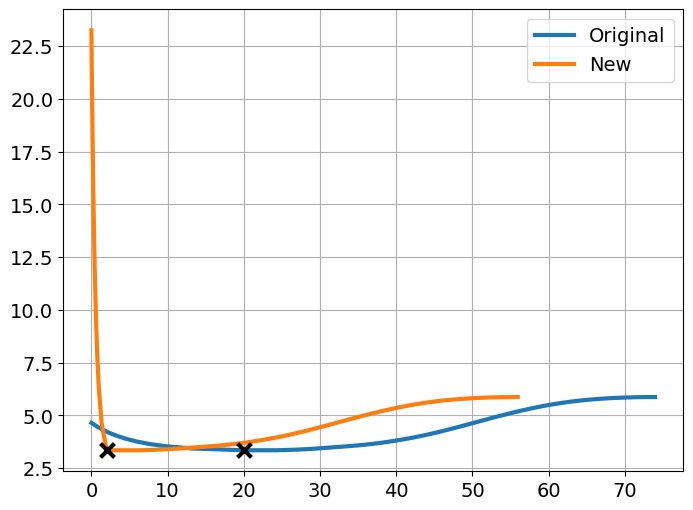

In [64]:
BxBt_scale = 0.2
Lc_scale = 0.1
design = "SPR38"
side = "iu"

d = copy.deepcopy(eqb[design][side])
constants = constants_default.copy()
radios = radios_default.copy()

Btot = d["Btot"].copy()
S = d["S"].copy()
Spol = d["Spol"].copy()
Xpoint = d["Xpoint"]
                    
d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                    
fig, ax = plt.subplots()
ax.plot(S, Btot, label = "Original")
ax.scatter(S[Xpoint], Btot[Xpoint], marker = "x", color = "k", s = 100, linewidth = 3, zorder = 10)

ax.plot(d["S"], d["Btot"], label = "New")
ax.scatter(d["S"][d["Xpoint"]], d["Btot"][d["Xpoint"]], marker = "x", color = "k", s = 100, linewidth = 3, zorder = 10)
ax.legend()

In [65]:
radios["upstreamGrid"] = True
constants["XpointIndex"] = d["Xpoint"] # Index of Xpoint
constants["nu0"] = 1e20

# Inner has 10% of the power.
if side == "iu":
    constants["qpllu0"] = constants_default["qpllu0"] * 0.1

SparRange = [0]    
out = LRBv21(constants, radios, d, SparRange, verbosity = 3, control_variable = "power", timeout = 10)

Solving...0...
---SOLVING FOR INDEX 0
qpllu0: 1.000E+08 | nu: 1.000E+20 | Tu: 77.3 | cz: 2.000E-02 | cvar: 1.71E-07 -> qpllu1: 2.085E+08 | Tucalc: 118.0 | error1: 2.085E+00

cvar: 1.708E-07, error1: 2.085E+00
qpllu0: 1.000E+08 | nu: 1.000E+20 | Tu: 77.3 | cz: 2.000E-02 | cvar: 8.54E-08 -> qpllu1: -1.867E+08 | Tucalc: 72.7 | error1: -1.867E+00
cvar: 8.541E-08, error1: -1.867E+00
Last error: 2.085E+00, New error: -1.867E+00
qpllu0: 1.000E+08 | nu: 1.000E+20 | Tu: 77.3 | cz: 2.000E-02 | cvar: 1.28E-07 -> qpllu1: 7.127E+07 | Tucalc: 107.5 | error1: 7.127E-01
>Bounds: 8.541E-08-1.281E-07, cvar: 1.281E-07, error1: 7.127E-01
qpllu0: 1.000E+08 | nu: 1.000E+20 | Tu: 77.3 | cz: 2.000E-02 | cvar: 1.07E-07 -> qpllu1: -3.629E+07 | Tucalc: 97.0 | error1: -3.629E-01
>Bounds: 1.068E-07-1.281E-07, cvar: 1.068E-07, error1: -3.629E-01
qpllu0: 1.000E+08 | nu: 1.000E+20 | Tu: 77.3 | cz: 2.000E-02 | cvar: 1.17E-07 -> qpllu1: 2.205E+07 | Tucalc: 103.1 | error1: 2.205E-01
>Bounds: 1.068E-07-1.174E-07, cvar: 1

In [ ]:
oldlogs = out["logs"][0]["error1"]

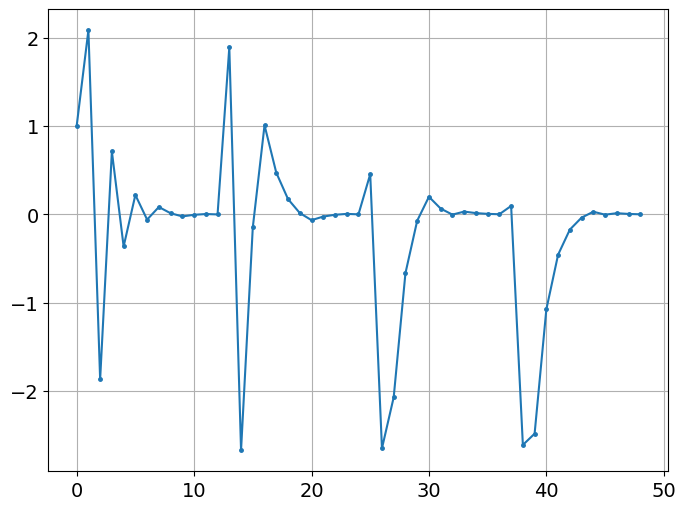

In [101]:
fig, ax = plt.subplots()

ax.plot(out["logs"][0]["error1"], marker = "o", ms = 2.5, lw = 1.5)